<img width="200" src="https://raw.githubusercontent.com/lukwies/mid-bootcamp-project/main/data/img/bikes.png">

---


# Bikesharing in Seoul / Prediction

---

### Sources

 * Data: https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand
 * Image: https://global.chinadaily.com.cn/a/201801/25/WS5a69cab3a3106e7dcc136a6d.html

---

### Tasks

 

In [62]:
import pandas as pd
import numpy as np
import yaml
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

#### Load YAML config file

In [63]:
with open('../params.yaml') as file:
    config = yaml.safe_load(file)

#### Load cleaned dataset

In [64]:
df = pd.read_csv(config['data']['csv_cleaned'])

#### Let's drop column date since we don't need it for prediction

In [65]:
df = df.drop(['date', 'daytime', 'seasons',
              'functioning_day', 'temperature_type',
              'solar_radiation'], axis=1)

### Do X/y-split

In [66]:
X = df.drop(['rented_bike_count'], axis=1)
y = df['rented_bike_count']

### Do train/test-split

In [67]:
X_train,X_test,y_train,y_test = train_test_split(X, y,
                                                 test_size=config['testsplit']['test_size'],
                                                 random_state=config['testsplit']['random_state'])

# Split training set into numerical and categorical columns
X_train_num = X_train.select_dtypes(np.number)
X_train_cat = X_train.select_dtypes(object)

# Split test set into numerical and categorical columns
X_test_num = X_test.select_dtypes(np.number)
X_test_cat = X_test.select_dtypes(object)

In [68]:
X_train_num.head()

,month,hour,weekday,temperature,humidity,wind_speed,visibility,rainfall,snowfall
6241,8,1,5,23.9,51,0.9,2000,0.0,0.0
3424,4,16,6,19.1,52,0.9,1583,0.0,0.0
6930,9,18,5,24.2,76,1.2,2000,0.0,0.0
6918,9,6,5,21.0,84,0.9,2000,0.1,0.0
60,12,12,6,5.8,85,1.7,349,0.0,0.0


In [69]:
X_train_cat.head()

,holiday
6241,No
3424,No
6930,No
6918,No
60,No


<br>

### Apply OneHotEncoder on categorical columns

In [70]:
ohe = OneHotEncoder(drop='first')
ohe.fit(X_train_cat)

X_train_cat_enc = ohe.transform(X_train_cat).toarray()
X_test_cat_enc  = ohe.transform(X_test_cat).toarray()

X_train_cat_enc = pd.DataFrame(X_train_cat_enc, columns=ohe.get_feature_names_out(), index=X_train_cat.index)
X_test_cat_enc  = pd.DataFrame(X_test_cat_enc, columns=ohe.get_feature_names_out(), index=X_test_cat.index)

#### Store OneHotEncoder to file

In [71]:
with open(config['encoder']['onehot'], 'wb') as file:
    pickle.dump(ohe, file, pickle.HIGHEST_PROTOCOL)

<br>

### Apply StandardScaler to numerical columns

In [72]:
stdScaler = StandardScaler()
stdScaler.fit(X_train_num)

X_train_num_scaled = stdScaler.transform(X_train_num)
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns, index=X_train_num.index)

X_test_num_scaled = stdScaler.transform(X_test_num)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)

#### Store StandardScaler to file

In [73]:
with open(config['scaler']['standard'], 'wb') as file:
    pickle.dump(stdScaler, file, pickle.HIGHEST_PROTOCOL)

<br>

### Apply MinMaxScaler to numerical columns

In [74]:
minmax = MinMaxScaler()
minmax.fit(X_train_num_scaled)

X_train_num_scaled = minmax.transform(X_train_num_scaled)
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns, index=X_train_num.index)

X_test_num_scaled = minmax.transform(X_test_num_scaled)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)

#### Store MinMaxScaler to file

In [75]:
with open(config['scaler']['minmax'], 'wb') as file:
    pickle.dump(minmax, file, pickle.HIGHEST_PROTOCOL)

### Build final dataframes

In [76]:
X_train_final = pd.concat([X_train_cat_enc, X_train_num_scaled], axis=1)
X_test_final  = pd.concat([X_test_cat_enc, X_test_num_scaled], axis=1)

<br>

### KNeighborRegression

In [77]:
n_neighbors = 5
knn = KNeighborsRegressor(n_neighbors, weights='distance')
knn.fit(X_train_final, y_train)

KNeighborsRegressor(weights='distance')

In [78]:
y_train_pred = knn.predict(X_train_final)
y_test_pred  = knn.predict(X_test_final)

train_score = knn.score(X_train_final, y_train)
test_score  = knn.score(X_test_final, y_test)

In [79]:
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

Train score: 1.0
Test score: 0.7799680191473284


#### Store KNN model to file

In [ ]:
with open(config['model']['KNN'], 'wb') as file:
    pickle.dump(knn, file, pickle.HIGHEST_PROTOCOL)

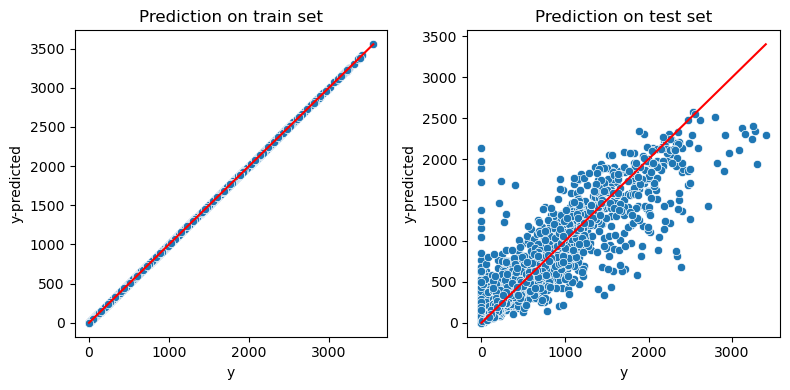

In [80]:
fig,ax = plt.subplots(1, 2, figsize=(8,4))

sx = sns.scatterplot(y=y_train_pred, x=y_train, ax=ax[0])
sx = sns.lineplot(y=y_train, x=y_train, color='red', ax=ax[0])
sx.set(title='Prediction on train set', xlabel='y', ylabel='y-predicted')

sx = sns.scatterplot(y=y_test_pred, x=y_test, ax=ax[1])
sx = sns.lineplot(y=y_test, x=y_test, color='red', ax=ax[1])
sx.set(title='Prediction on test set', xlabel='y', ylabel='y-predicted')

plt.tight_layout()
plt.show()

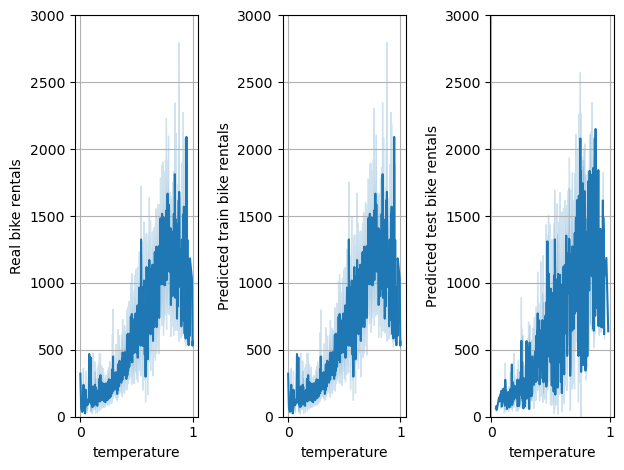

In [81]:
fig,ax = plt.subplots(1,3)

sax = sns.lineplot(data=X_train_final, x='temperature', y=y_train, ax=ax[0])
sax.set(ylabel='Real bike rentals', ylim=(0,3000))
sax.grid()

sax = sns.lineplot(data=X_train_final, x='temperature', y=y_train_pred, ax=ax[1])
sax.set(ylabel='Predicted train bike rentals', ylim=(0,3000))
sax.grid()

sax = sns.lineplot(data=X_test_final, x='temperature', y=y_test_pred, ax=ax[2])
sax.set(ylabel='Predicted test bike rentals', ylim=(0,3000))
sax.grid()

plt.tight_layout()
plt.show()

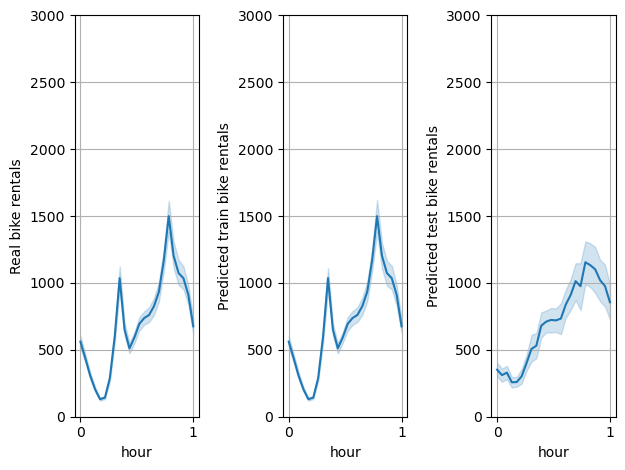

In [82]:
fig,ax = plt.subplots(1,3)

sax = sns.lineplot(data=X_train_final, x='hour', y=y_train, ax=ax[0])
sax.set(ylabel='Real bike rentals', ylim=(0,3000))
sax.grid()

sax = sns.lineplot(data=X_train_final, x='hour', y=y_train_pred, ax=ax[1])
sax.set(ylabel='Predicted train bike rentals', ylim=(0,3000))
sax.grid()

sax = sns.lineplot(data=X_test_final, x='hour', y=y_test_pred, ax=ax[2])
sax.set(ylabel='Predicted test bike rentals', ylim=(0,3000))
sax.grid()

plt.tight_layout()
plt.show()

Neighbours=2 score=0.7460529420048272
Neighbours=3 score=0.7534058945974109
Neighbours=4 score=0.752099000197846
Neighbours=5 score=0.7539331199885012
Neighbours=6 score=0.7481274215243214
Neighbours=7 score=0.7471533239964753
Neighbours=8 score=0.7406089122835209
Neighbours=9 score=0.7340983190658357
Neighbours=10 score=0.7288358131065051
Neighbours=11 score=0.7297726749580671
Neighbours=12 score=0.7255670460837871
Neighbours=13 score=0.7151310596279743
Neighbours=14 score=0.712583792113573
Neighbours=15 score=0.7101708611737607
Neighbours=16 score=0.7063489946954924
Neighbours=17 score=0.7062291626978233
Neighbours=18 score=0.7027237070082799
Neighbours=19 score=0.7010434687596412
Neighbours=20 score=0.6991070173620266
Neighbours=21 score=0.6965384019191239
Neighbours=22 score=0.6955712396357928
Neighbours=23 score=0.6932320791423359
Neighbours=24 score=0.6904624002750781
Neighbours=25 score=0.6886151899124454
Neighbours=26 score=0.6870834977848234
Neighbours=27 score=0.6843339161109

Text(0, 0.5, 'R2')

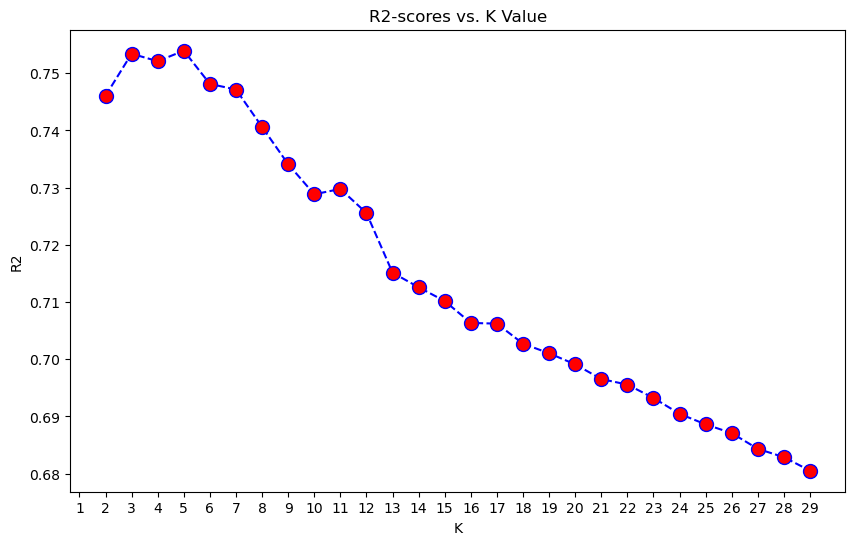

In [83]:
scores = []
for k in range(2,30):
    model = KNeighborsRegressor(n_neighbors=k)

    model.fit(X_train_final, y_train)
   # knn_models.append(model)

    score = model.score(X_test_final, y_test)
    scores.append(score)
    print(f'Neighbours={k} score={score}')

plt.figure(figsize=(10,6))
plt.plot(range(2,30), scores, color = 'blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
plt.title('R2-scores vs. K Value')
plt.xticks(range(1,30))
#plt.gca().invert_yaxis()
plt.xlabel('K')
plt.ylabel('R2')